In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils.vis_utils import plot_model

import data_preprocessing as dp
import utilities
import models.training as train
import models.autoencoder
from models.autoencoder import ConvolutionalAutoencoder

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Create Dataset with EEG-Data compressed by trained Autoencoder

```python
data, events = dp.load_data()
data, events = dp.choose_condition(data, events, 'inner speech')
norm_data = data.astype(np.float16) * 100_000  # NORMALIZATION ONLY POSSIBLE BY MULTIPLYING HERE?
norm_data = dp.normalization(norm_data)

dataset = tf.data.Dataset.from_tensor_slices((norm_data, events[:, 1]))
dataset = dp.preprocessing_pipeline(
    dataset,
    functions = [dp.filter_interval_tensor,
                 lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                 lambda sample: (tf.reshape(sample[0], (128, 640, 1)),
                                 sample[1])],
    args = [[[1, 3.5], 256], [], []],
    batch_size = 12
)

# save dataset so that we can just load the preprocessed version next time
tf.data.experimental.save(dataset, 'dataset/preprocessed/auto_class_ds')
```

In [2]:
# load datasets
datasets = {key:tf.data.experimental.load(f'dataset/preprocessed/new_full_ds_bs3/{key}') for key in ('train', 'test', 'valid')}

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-12 11:14:27.166113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-12 11:14:27.166224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# load dataset created previously
##dataset = tf.data.experimental.load('dataset/preprocessed/auto_class_ds')
# Load autoencoder-model
autoencoder_trained = tf.keras.models.load_model('./models/saved_models/autoencoder_20Epochs_train_split_bs3')
# create dataset by extracting latent space for every sample
autoencoded_datasets = {key:models.autoencoder.latent_dataset(autoencoder_trained.encoder, ds) for key, ds in datasets.items()}
##autoencoded_dataset = autoencoded_dataset.shuffle(200)
##autoencoded_datasets = dp.split_dataset(autoencoded_dataset)

tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)


2022-03-12 11:14:28.252084: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-12 11:14:28.257414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 40, 3)


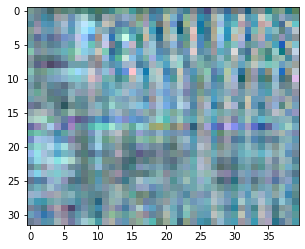

In [4]:
for i, t in autoencoded_datasets['valid'].take(1):
    print(t[0])
    # normalize
    norm_enc = i[0] / np.max(i[0], (0, 1))[np.newaxis, np.newaxis, :]
    plt.imshow(norm_enc)
    print(norm_enc.shape)

### Classify Autoencoded Dataset

In [5]:
#from models.classifiers import ConvAuto1

#model1 = ConvAuto1()
#model1.build((12, 32, 40, 3))
#model1.summary()

Model: "conv_auto2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  18464     
                                                                 
 batch_normalization_1 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   multiple                  0

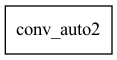

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Normalization, LeakyReLU, Activation, BatchNormalization, MaxPool2D



class ConvAuto1(Model):
    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(ConvAuto1, self).__init__()

        self.layer_list = [
            #Conv2D(filters=32, kernel_size=(3,3)),
            #LeakyReLU(),
            #Dropout(0.3),
            Conv2D(filters=32, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            MaxPool2D(),
            Conv2D(filters=32, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3),
            MaxPool2D(),
            Conv2D(filters=32, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            tf.keras.layers.GlobalAveragePooling2D(),
            Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active 
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

class ConvAuto2(Model):
    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(ConvAuto2, self).__init__()

        self.layer_list = [
            Conv2D(filters=64, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(filters=32, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3),
            Conv2D(filters=8, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            tf.keras.layers.GlobalAveragePooling2D(),
            Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active 
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

model1 = ConvAuto2()
model1.build((12, 32, 40, 3))
model1.summary()

model_name = '32_32_8_20Epochs'
plot_model(model1, to_file=f'./models/saved_models/classifiers/{model_name}_info.png', show_shapes=True, show_layer_names=True, expand_nested=True)


In [7]:
print([len(list(ds)) for ds in autoencoded_datasets.values()])

2022-03-12 11:14:29.365159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
%matplotlib tk

# Initialize the loss-function
loss_func = tf.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()
# Initialize Train-Object
trainer = train.Trainer(model1, autoencoded_datasets,
                        optimizer, loss_func, train.accuracy)
# Initialize Plotting-Object
grapher = utilities.TrainingGrapher(3,1, supxlabel='Epochs', axs_xlabels=[['Train Loss', 'Test Loss', 'Test Accuracy']])

trainer.model_test()
for epoch in range(20):
    print("Epoch:", epoch, trainer.losses['train'], end='\r')
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test'], trainer.accuracies['test']])

print(trainer.test('valid'))


2022-03-12 11:05:14.627560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:14.696396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:21.553435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:21.825292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-12 11:05:28.612899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:28.721337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:28.778861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:37.301116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:37.347259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:37.605125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:39.050076: I tensorflow/core/grappler/optimizers/cust

2022-03-12 11:05:39.385546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:47.713871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-12 11:05:49.292388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-12 11:05:57.606612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-12 11:05:59.191001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
%matplotlib inline
#rapher.fig.set_size_inches(18.5, 10.5)
grapher.fig

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model1.save(f'./models/saved_models/classifiers/{model_name}')
grapher.fig.savefig(f'./models/saved_models/classifiers/{model_name}_info')